# 载入套件

In [3]:
from typing import Dict
import numpy as np
import pandas as pd

import ydata_profiling
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

%matplotlib inline

pd.plotting.register_matplotlib_converters()
plt.style.use(['fivethirtyeight', 'science', 'grid'])
sns.set(
    rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)


# 载入数据

In [4]:
# 辅助表格，给出4214个常用APP所属类别
app = pd.read_csv('../Datasets/app_class.csv', header=None)
app.columns = ['appid', 'app_class']
print('app:', app.shape)

# 某年连续30天的4万多智能手机用户的监测数据
# 初赛数据集，仅含1～21天
day: Dict[int, pd.DataFrame] = {}
for i in range(1, 8):
    # 读取数据，增加列标签，便于索引
    day[i] = pd.read_csv(f'../Datasets/day{str(i).zfill(2)}.txt', header=None)
    day[i].columns = ['uid', 'appid', 'app_type', 'start_day', 'start_time',
                      'end_day', 'end_time', 'duration', 'up_flow', 'down_flow']

    # 数据融合：将辅助表格链接至每日监测数据表格
    day[i] = day[i].merge(app, on='appid', how='left')

    # 数据清洗：仅保留使用时长小于一天（24*60*60秒）的资料
    # 1～7天中，平均每日有15条异常值
    # TODO: 验证duration是否计算错误。
    day[i] = day[i].query('duration <= 86400')

    # 数据清洗：仅保留已知所属类别的常用APP，遗弃其余不常用APP
    # TODO: 验证NaN是否存在语义信息。
    day[i].dropna(inplace=True, axis='index')
    print(f'day{str(i).zfill(2)}:', day[i].shape)


app: (4214, 2)
day01: (3178319, 11)
day02: (3076184, 11)
day03: (3003340, 11)
day04: (2746760, 11)
day05: (2671643, 11)
day06: (2691100, 11)
day07: (2163212, 11)


# 数据直觉

- 屏幕使用时间报告
    - 周报
        - 总屏幕使用时长（日均）
        - 每日各类app总使用时长
        - 总通知/拿起次数（日均）
        - 每日各类app总通知/拿起次数
    - 日报
        - 粒度更细，屏幕使用时间与通知/拿起次数以小时为单位

APP所属类别可划分为：
1. 娱乐，如哔哩哔哩、腾讯视频、网易云音乐
2. 效率与财务，如钉钉、日历、备忘录、百度网盘
3. 社交，如QQ、微信、知乎
4. 旅行，如地图
5. 购物与美食，如淘宝、美团外卖
6. 信息与阅读，如天气
7. 创意，如相机、美图秀秀
8. 工具，如QQ邮箱、AppStore
9. 教育，如校园助手、DataCamp
10. 健康与健身，如Keep

# 数据探索

## Q1: 屏幕使用时间

以`BB1657CFD3B4B7208674BEB7D26014B2`用户为例，首先制作day01日报，然后进而制作day01～day07周报。

### Q1.0 数据有哪几列，分别代表什么含义

In [5]:
day[1].columns


Index(['uid', 'appid', 'app_type', 'start_day', 'start_time', 'end_day',
       'end_time', 'duration', 'up_flow', 'down_flow', 'app_class'],
      dtype='object')

### Q1.1 是否存在App跨天的情况？

In [6]:
day[1].describe()


,appid,start_day,end_day,duration,up_flow,down_flow
count,3.178319e+06,3.178319e+06,3178319.0,3.178319e+06,3.178319e+06,3.178319e+06
mean,1.054534e+04,9.988472e-01,1.0,9.459145e+01,1.063961e+06,2.764850e+05
std,7.392332e+03,3.393349e-02,0.0,3.624871e+02,1.450479e+07,8.508721e+06
min,4.000000e+00,0.000000e+00,1.0,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.309000e+03,1.000000e+00,1.0,5.000000e+00,0.000000e+00,0.000000e+00
50%,9.498000e+03,1.000000e+00,1.0,1.800000e+01,3.680000e+02,4.850000e+02
75%,1.675900e+04,1.000000e+00,1.0,6.600000e+01,2.880500e+04,6.557000e+03
max,2.360800e+04,1.000000e+00,1.0,6.129100e+04,3.639474e+09,3.292713e+09


In [7]:
i = 3

tmp = day[i].query("start_day != @i")
print(tmp.shape)
print(tmp['start_day'].unique())

tmp


(3597, 11)
[2]


,uid,appid,app_type,start_day,start_time,end_day,end_time,duration,up_flow,down_flow,app_class
146,D6591D51D637ED019E1143B767736BCF,17442,usr,2,23:55:00,3,00:02:58,478,247349,111217,e
148,4F07ADD27DCE1A7B6919749EE986C904,17325,usr,2,23:50:32,3,00:04:35,843,5861999,188057,q
157,C9DDABFBD4F1A323B847F2DF17226281,3309,usr,2,23:57:08,3,00:00:04,175,494566,56808,f
164,AAE4566EF2C2070E0153C847BE2D633D,21776,usr,2,23:57:08,3,00:00:03,174,1117847,118439,g
177,DAE05F8519C3944D78A594610DBA9245,3309,usr,2,23:59:22,3,00:00:42,79,0,0,f
...,...,...,...,...,...,...,...,...,...,...,...
5709702,E956E3C0340391D0F2C49E022F0BBAC0,16759,usr,2,23:56:02,3,00:00:45,282,0,0,f
5715931,F9D876EF0A9C8CBD415FB6F06CC90807,15629,usr,2,23:57:47,3,00:00:02,134,9643,3796,t
5716573,BE2322A35946C727803814D8C64EF809,17442,usr,2,23:50:10,3,00:15:56,1546,0,0,e
5716622,BE2322A35946C727803814D8C64EF809,17442,usr,2,23:50:10,3,00:15:56,1546,0,0,e


### Q1.2 day01日报

In [8]:
uid = 'BB1657CFD3B4B7208674BEB7D26014B2'
df = day[1].query('uid == @uid')


In [9]:
df[df['app_class'] == 'a'].shape


(98, 11)

In [10]:
# 每类 app 的使用总时长
duration_agg_by_app = df[['duration', 'app_class']
                         ].groupby(by='app_class').sum()

# 每类 app 的活跃（拿起/通知）次数
count_agg_by_app = df[['duration', 'app_class']
                      ].groupby(by='app_class').count()


In [11]:
# 每类 app 的 24 小时 分布（使用时长）
temp = df.sort_values(by='end_time')[
    ['start_time', 'end_time', 'app_class']].values
counter_hour_app: dict[int, int] = {i: {} for i in range(24)}


> 头脑风暴：频次（距离上一次记录的时间间隔）、工作日与节假日（星期数）

### Q1.3 周报

In [12]:
# TODO


## Q2: 无线局域网和蜂窝网络

> 头脑风暴：

/Users/durui/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


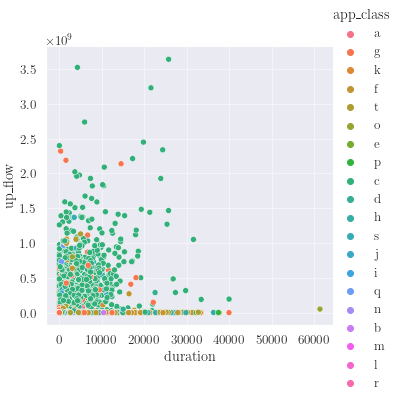

In [13]:
sns.relplot(data=day[1],  x='duration', y='up_flow',
            kind='scatter', hue='app_class')


In [17]:
profile = ydata_profiling.ProfileReport(
    df=df[['duration', 'up_flow', 'down_flow', 'app_class']])
profile.to_file("report.html")


/Users/durui/opt/anaconda3/lib/python3.9/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]